### Copied from: https://ps1images.stsci.edu/ps1image.html#Get-image-from-the-PS1-image-server

# Get image from the PS1 image server
#### Query the PS1 image server to get a list of images and retrieve some images. This sample script demonstrates the use of the PS1 image services. See the PS1 Image Cutout Service documentation for details of the services being used. This notebook is available for download.

In [9]:
%matplotlib inline
from __future__ import print_function
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

# Helper functions to query the list of images and to extract images

In [2]:
def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

# Sample JPEG images
#### This gets single-band grayscale and color JPEG images at the position of the Crab Nebula. The extracted region size is 1280 pixels = 320 arcsec.

In [3]:
# Crab Nebula position
ra = 83.633210
dec = 22.014460
size = 1280

# grayscale image
gim = getgrayim(ra,dec,size=size,filter="i")
# color image
cim = getcolorim(ra,dec,size=size,filters="grz")


NameError: name 'jpeg_lis' is not defined

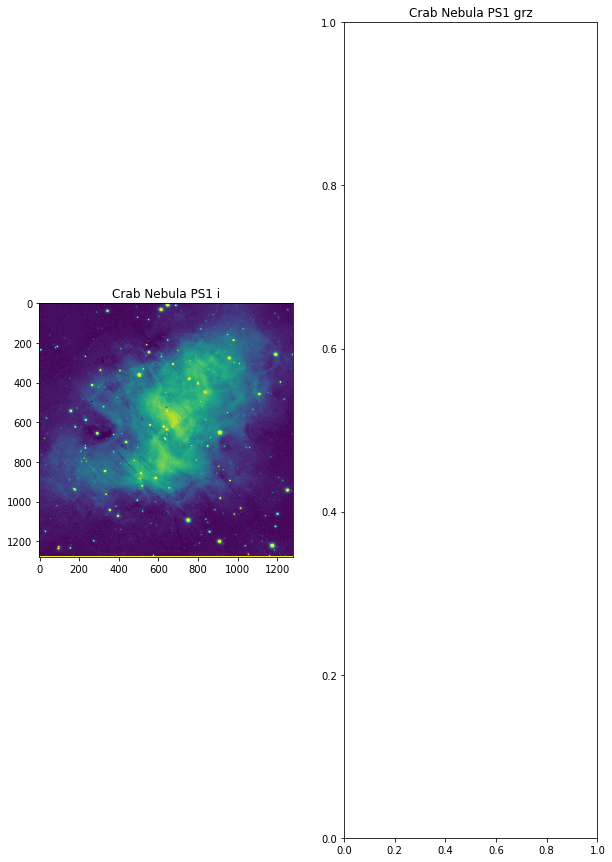

In [4]:
fig = plt.figure(1,(10,15))

plt.subplot(121)
plt.imshow(np.asarray(gim),origin="upper")
plt.title('Crab Nebula PS1 i')

plt.subplot(122)
plt.title('Crab Nebula PS1 grz')
plt.imshow(jpeg_lis[1],origin="upper")

# Load and display a FITS image
#### Note that the  y-axis is flipped in the JPEG image compared with the original FITS image.

In [5]:
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch

fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fim = fh[0].data
# replace NaN values with zero for display
fim[numpy.isnan(fim)] = 0.0
# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bfim = transform(fim)

Text(0.5,1,u'Crab Nebula PS1 i (fits)')

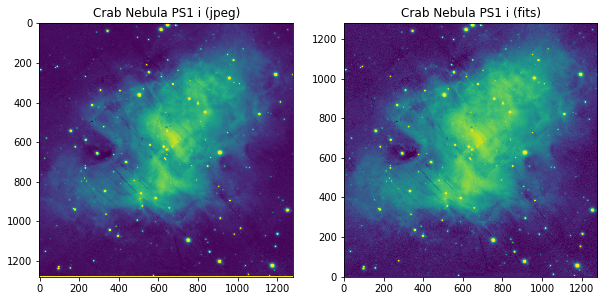

In [6]:
fig = plt.figure(1,(10,15))

plt.subplot(121)
plt.imshow(np.asarray(gim),origin="upper")
plt.title('Crab Nebula PS1 i (jpeg)')

plt.subplot(122)
plt.imshow(bfim,origin="lower")
plt.title('Crab Nebula PS1 i (fits)')


# Build HPS cutout image

In [5]:
hps = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_all_props.csv')
print(len(hps))

29


In [6]:
jpeg_lis = []
id_lis   = []
name_lis = []
sel_lis  = []
for i in range(len(hps)):
    obj = hps.iloc[i]
    print(i, obj['HPS_name'], obj['ID'], obj['Selection'])
    
    # color image
    #size in pixels (0.25 arcsec/pix)
    size=60 #15arcsec
    cim = getcolorim(obj['RA'], obj['DEC'], size=size, filters="grz") 

    jpeg_lis.append(cim)
    id_lis.append(obj['ID'])
    name_lis.append(obj['HPS_name'])
    sel_lis.append(obj['Selection'])

0 HPS030638+000015 65.0 [OII]3727
1 HPS022127-043019 35.0 [OII]3727
2 HPS030649+000314 105.0 [OII]3727
3 HPS030657+000139 138.0 [OII]3727
4 HPS100018+021818 219.0 [OII]3727
5 HPS100018+021426 225.0 [OII]3727
6 HPS100032+021356 278.0 [OII]3727
7 HPS100045+021823 326.0 [OII]3727
8 HPS123636+621135 375.0 [OII]3727
9 HPS123641+621131 386.0 [OII]3727
10 HPS123648+621426 413.0 [OII]3727
11 HPS123659+621404 449.0 [OII]3727
12 HPS123702+621123 458.0 [OII]3727
13 HPS030630+000128 44.0 [OII]3727
14 HPS030638+000240 67.0 [OII]3727
15 HPS030651-000234 118.0 [OII]3727
16 HPS030652+000123 119.0 [OII]3727
17 HPS030655+000213 129.0 [OII]3727
18 HPS030655-000050 125.0 [OII]3727
19 HPS100008+021542 158.0 [OII]3727
20 HPS100021+021223 235.0 [OII]3727
21 HPS100021+021237 237.0 [OII]3727
22 HPS100028+021858 260.0 [OII]3727
23 HPS100037+021254 300.0 [OII]3727
24 HPS100039+021246 303.0 [OII]3727
25 HPS123632+621037 363.0 [OII]3727
26 HPS123656+621420 438.0 [OII]3727
27 HPS100021+021351 234.0 [OIII]5007
28 HP

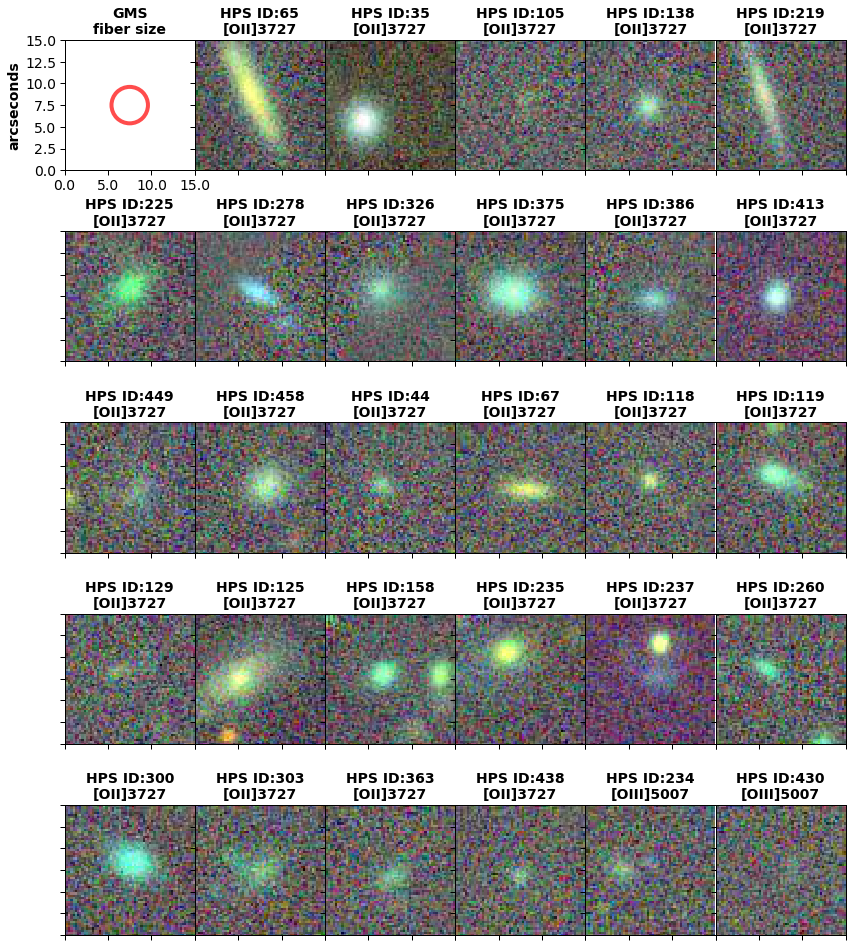

In [18]:
plot_path = '/Users/Briana/Documents/Grad_School/HPS/Paper_Plots'
sns.set_context('paper')

fig, ax2d = plt.subplots(5, 6, figsize=(14,17), squeeze=False)
ax = ax2d.flatten()

for i in range(len(hps)):    
    # color image
    j = i+1
    cim = jpeg_lis[i]

    ax[j].imshow(cim,origin="upper")
    ax[j].set_title('HPS ID:'+str(int(id_lis[i])) + '\n'+ str(sel_lis[i]), fontweight='bold', fontsize=14)
    ax[j].set_yticklabels([])
    ax[j].set_xticklabels([])
    ax[j].set_xlim(0, 60)
    ax[j].set_ylim(0, 60)
    
fibsize = 4.2 #arcseconds
circle = plt.Circle((30.0, 30.0), radius=((fibsize/0.25)/2.0), lw=4, ec='red', fc='none', alpha=0.7)
ax[0].add_artist(circle)
ax[0].set_title('GMS'+'\n'+'fiber size', fontsize=14, fontweight='bold')
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
ax[0].set_aspect(asp)
ax[0].set_xlim(0, 60)
ax[0].set_ylim(0, 60)
a_x =np.array(ax[0].get_xticks().tolist())
a_y =np.array(ax[0].get_yticks().tolist())
ax[0].set_ylabel('arcseconds', fontsize=14, fontweight='bold')
ax[0].set_xticklabels(a_x*0.25, fontsize=14)
ax[0].set_yticklabels(a_y*0.25, fontsize=14)
#ax[0].tick_params(axis='both', which='major', labelsize=12)
 
plt.subplots_adjust(wspace=0.0, hspace=0.2)
plt.savefig(os.path.join(plot_path, 'PanSTARRS_hps_cutouts.pdf'), bbox_inches='tight')
plt.show()